The quality of casting is crucial in ensuring the safety and reliability of engineering structures. 

Casting defects can occur during the manufacturing process, leading to compromised performance, reduced durability, and potentially catastrophic failures. Automated defect detection using computer vision techniques is a promising solution to address this issue. 

In this project, I propose a **simple convolutional neural network (CNN) model for binary classification of casting defects**. This model is designed to classify castings as either defective or non-defective based on images captured during the production process and it achieved 97.5% acuuracy and 97.4% F-1 score.

For this work I used a "casting product image data for quality inspection" dataset which contains 6633 already augmented images of front view of a casting product in the train set, and 715 respective images in the test set.

Dataset: https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product


In [31]:
#Importing all of the relevant libraries and modules
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision

!pip install torchinfo
import torchinfo
!pip install torcheval
from torcheval import metrics

import os

import random
from PIL import Image

from tqdm.auto import tqdm 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
# Device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [52]:
# Setup path to image folder
main_path = Path('/content/drive/MyDrive/casting_defects/casting_data')
# Checking if the image folder exists
if main_path.is_dir():
  print(f"{main_path} directory exists")

/content/drive/MyDrive/casting_defects/casting_data directory exists


In [53]:
# Setting up the train and test paths
train_path = main_path / 'train'
test_path = main_path / 'test'
train_path, test_path

(PosixPath('/content/drive/MyDrive/casting_defects/casting_data/train'),
 PosixPath('/content/drive/MyDrive/casting_defects/casting_data/test'))

In [54]:
# To inspect what is in our data directory we will use Python's in-built "os.walk()"
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
    
walk_through_dir(main_path)

There are 2 directories and 0 images in /content/drive/MyDrive/casting_defects/casting_data
There are 2 directories and 0 images in /content/drive/MyDrive/casting_defects/casting_data/test
There are 0 directories and 453 images in /content/drive/MyDrive/casting_defects/casting_data/test/def_front
There are 0 directories and 262 images in /content/drive/MyDrive/casting_defects/casting_data/test/ok_front
There are 2 directories and 0 images in /content/drive/MyDrive/casting_defects/casting_data/train
There are 0 directories and 3758 images in /content/drive/MyDrive/casting_defects/casting_data/train/def_front
There are 0 directories and 2875 images in /content/drive/MyDrive/casting_defects/casting_data/train/ok_front


Random image path: /content/drive/MyDrive/gear_defect/casting_data/train/ok_front/cast_ok_0_142.jpeg
Image class: ok_front
Image height: 300
Image width: 300


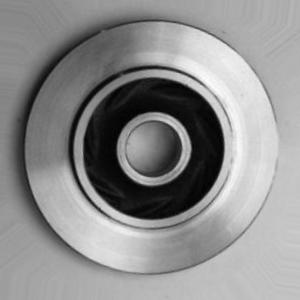

In [36]:
# Set random seed
random.seed(77)

# Get all image paths
main_path_list = list(main_path.glob("*/*/*.jpeg"))

# Get random image path
random_image_path = random.choice(main_path_list)

# Get image class from path name of the image
image_class = random_image_path.parent.stem

# Open image
img = Image.open(random_image_path)

# Print metadata of the image
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')
img


In [37]:
# Transformation of the image
data_transform = torchvision.transforms.Compose([
    # Drop 2 channels, since the original images are gray-scaled
    torchvision.transforms.Grayscale(num_output_channels=1),
    # Resizing the images to 64 x 64
    torchvision.transforms.Resize(size = (64,64)),
    # Turn images into tensors
    torchvision.transforms.ToTensor(),
    # Normalize the inputs
    torchvision.transforms.Normalize(mean = 0.5642, std = 0.2273)
])

In [38]:
# And now we will create a dataset using tochvisiom.datasets.ImageFolder
train_data = torchvision.datasets.ImageFolder(root = train_path, #targer folder of imgs
                                  transform = data_transform, #perform data_transform on images
                                  target_transform = None) #transforms to perform on labels

test_data = torchvision.datasets.ImageFolder(root = test_path, #targer folder of imgs
                                  transform = data_transform, #perform data_transform on images
                                  target_transform = None) #transforms to perform on labels

print(f"Train data: \n{train_data}")
print(f"Test data: \n{test_data}")

Train data: 
Dataset ImageFolder
    Number of datapoints: 6633
    Root location: /content/drive/MyDrive/gear_defect/casting_data/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=0.5642, std=0.2273)
           )
Test data: 
Dataset ImageFolder
    Number of datapoints: 715
    Root location: /content/drive/MyDrive/gear_defect/casting_data/test
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=0.5642, std=0.2273)
           )


This block of code below was used to find the mean and std of the original tensors for normalization
It was run before creating a Normalization data transformation

In [39]:
from PIL import ImageStat
class Stats(ImageStat.Stat):
  def __add__(self, other):
    # add self.h and other.h element-wise
    return Stats(list(np.add(self.h, other.h)))

loader = DataLoader(train_data, batch_size=8, num_workers=os.cpu_count()) #Creating a dataloader to calculate mean and std

statistics = None

for batch,(X,y) in enumerate(loader):
  for x in X:
    if statistics is None:
      statistics = Stats(torchvision.transforms.functional.to_pil_image(x))
    else:
      statistics += Stats(torchvision.transforms.functional.to_pil_image(x))

print(statistics.mean[0]/255)
print(statistics.stddev[0]/255.)
  

KeyboardInterrupt: ignored

In [40]:
# Get class names and indices
class_dict = train_data.class_to_idx
class_dict

{'def_front': 0, 'ok_front': 1}

In [41]:
# Checking the lengths of train and test sets
len(train_data), len(test_data)

(6633, 715)

In [42]:
# Creating two dataloaders
BATCH_SIZE = 8
NUM_WORKERS = os.cpu_count()
print(f'Batch size: {BATCH_SIZE} and num_of_workers: {NUM_WORKERS}')
train_dataloader = DataLoader(dataset = train_data,
                               batch_size = BATCH_SIZE,
                               num_workers = NUM_WORKERS,
                               shuffle = True)
test_dataloader = DataLoader(dataset = test_data,
                               batch_size = BATCH_SIZE,
                               num_workers = NUM_WORKERS)
train_dataloader, test_dataloader

Batch size: 8 and num_of_workers: 2


(<torch.utils.data.dataloader.DataLoader at 0x7fca68291db0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fca68292b60>)

In [ ]:
# Checking that the shape of the tensor is correct
img, label = next(iter(train_dataloader))
img.shape

In [43]:
class LiteModel(nn.Module):
  def __init__(self, input_channels:int, output_shape:int, num_of_kernels:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_channels,
                  out_channels = num_of_kernels,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Dropout2d(),
        nn.Conv2d(in_channels = num_of_kernels,
                  out_channels = num_of_kernels,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = num_of_kernels,
                  out_channels = num_of_kernels,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 16 * 16 * num_of_kernels,
                  out_features = 16*16*num_of_kernels),
        nn.Dropout(),
        nn.Linear(in_features = 16*16*num_of_kernels,
                  out_features = output_shape)
    )
  
  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x



In [44]:
# Creating a model
torch.manual_seed(77)
model = LiteModel(input_channels = 1,
                  num_of_kernels =10,
                  output_shape = len(train_data.classes)).to(device)

In [45]:
# Getting detailed summary of the model using torchinfo's summary() method
torchinfo.summary(model, input_size=[1,1,64,64])

/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
LiteModel                                [1, 2]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           100
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-3                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Dropout2d: 2-4                    [1, 10, 32, 32]           --
│    └─Conv2d: 2-5                       [1, 10, 32, 32]           910
│    └─ReLU: 2-6                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-7                       [1, 10, 32, 32]           910
│    └─ReLU: 2-8                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-9                    [1, 10, 16, 16]           --
├─Sequential: 1-3                        [1, 2]                    --
│    └─Flatt

In [ ]:
# Checking if the model is built correctly and it's giving predictions
img_batch, label_batch = next(iter(train_dataloader))
img_single, label_single = img_batch[0], label_batch[0]
model.eval()
with torch.inference_mode():
  pred = model(img_single.unsqueeze(dim = 0).to(device))
pred, label_single

In [46]:
def train_step(model : nn.Module,
               train_dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer):
  train_loss, train_acc = 0,0 
  model.train() # Putting the model in a train mode

  for batch, (X,y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device) # Sending tensors to the device
    # Forward pass
    y_hat = model(X)
    # Calculate and accumulate the loss
    loss = loss_fn(y_hat, y)
    train_loss += loss.item()
    # Optimizer zero-grad
    optimizer.zero_grad()
    # Backprop
    loss.backward()
    # Optimizer step
    optimizer.step()
    # Calculating and accumulating accuracy
    y_pred_class = torch.argmax(torch.softmax(y_hat, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y_hat)
  # Averaging out the loss and accuracy
  train_loss = train_loss / len(train_dataloader)
  train_acc = train_acc / len(train_dataloader)

  return train_loss, train_acc


In [47]:
def test_step(model: nn.Module,
              test_dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module):
  test_loss, test_acc = 0,0
  model.eval() #Putting a model in a test mode
  for batch, (X,y) in enumerate(test_dataloader):
    X, y = X.to(device), y.to(device) # Sending tensors to the device
    # Forward pass
    y_hat = model(X)
    # Calculating a loss
    loss = loss_fn(y_hat, y)
    # Accumulating a loss
    test_loss += loss.item()
    # Calculating and accumulating accuracy
    y_pred_class = torch.argmax(torch.softmax(y_hat, dim=1), dim=1)
    test_acc += (y_pred_class == y).sum().item() / len(y_hat)
  # Averaging out the loss and accuracy
  test_loss = test_loss / len(test_dataloader)
  test_acc = test_acc / len(test_dataloader)
  return test_loss, test_acc



In [48]:
def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: nn.CrossEntropyLoss(),
          scheduler: torch.optim.lr_scheduler,
          epochs: int):
  # Creating a dictionary to track model's performance
  results = {"train_loss":[],
             "train_accuracy":[],
             'test_loss':[],
             'test_accuracy':[]}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model, train_dataloader = train_dataloader, loss_fn = loss_fn, optimizer = optimizer)
    scheduler.step(train_acc) # Step of the learning rate scheduler
    current_lr = scheduler.state_dict()['_last_lr'][0] # Loading current learning rate
    test_loss, test_acc = test_step(model = model, test_dataloader = test_dataloader, loss_fn = loss_fn)
    print(f'Epoch:{epoch + 1} // Train loss:{train_loss:.4f} // Train accuracy: {train_acc:.4f} // Test loss:{test_loss:.4f} // Test accuracy: {test_acc:.4f} // Learning rate:{current_lr}')

    # Appending the "results" dictionary
    results['train_loss'].append(train_loss)
    results['train_accuracy'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_accuracy'].append(test_acc)

  return results

In [49]:
loss_fn = nn.CrossEntropyLoss() # Setting up the loss function
optimizer = torch.optim.Adam(params =model.parameters(), lr = 0.001) # Settng up the optimizer
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer, factor=0.5, patience = 3) #Setting up the lr scheduler
EPOCHS = 20 # Number of epochs

In [ ]:
results = train(model= model, train_dataloader = train_dataloader,
                test_dataloader = test_dataloader,
                optimizer = optimizer, scheduler = scheduler,
                loss_fn = loss_fn, epochs = EPOCHS)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:1 // Train loss:0.4363 // Train accuracy: 0.7898 // Test loss:0.3108 // Test accuracy: 0.8722 // Learning rate:0.001
Epoch:2 // Train loss:0.3085 // Train accuracy: 0.8676 // Test loss:0.2350 // Test accuracy: 0.8829 // Learning rate:0.001
Epoch:3 // Train loss:0.2532 // Train accuracy: 0.8950 // Test loss:0.2019 // Test accuracy: 0.9194 // Learning rate:0.001
Epoch:4 // Train loss:0.2109 // Train accuracy: 0.9179 // Test loss:0.2771 // Test accuracy: 0.8551 // Learning rate:0.001
Epoch:5 // Train loss:0.1884 // Train accuracy: 0.9264 // Test loss:0.1065 // Test accuracy: 0.9708 // Learning rate:0.0005
Epoch:6 // Train loss:0.1380 // Train accuracy: 0.9494 // Test loss:0.0887 // Test accuracy: 0.9736 // Learning rate:0.0005
Epoch:7 // Train loss:0.1238 // Train accuracy: 0.9514 // Test loss:0.1270 // Test accuracy: 0.9505 // Learning rate:0.0005
Epoch:8 // Train loss:0.1041 // Train accuracy: 0.9634 // Test loss:0.1023 // Test accuracy: 0.9653 // Learning rate:0.0005
Epoch:9 // T

In [ ]:
# Defining a function to plot the loss curves
def plot_loss_curves(results):
    
    # Get the loss values of the results dictionary (training and test)
    train_loss = results['train_loss']
    test_loss = results['test_loss']
    # Get the accuracy values of the results dictionary (training and test)
    train_accuracy = results['train_accuracy']
    test_accuracy = results['test_accuracy']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, test_loss, label='test_loss')
    plt.plot(epochs, train_loss, label='train_loss')
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.plot(epochs, train_accuracy, label='train_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [ ]:
plot_loss_curves(results)

In [25]:
# Creating a function to calculate F-1 score of our model
def f1_score(model: nn.Module,
             test_dataloader: torch.utils.data.DataLoader):
  y_pred_class = []
  # Making predictions
  model.eval()
  for batch, (X,y) in enumerate(test_dataloader):
    X, y = X.to(device), y.to(device)
    y_hat = model(X)
    y_pred_class += torch.argmax(torch.softmax(y_hat, dim=1), dim=1)
 
  # Turning 2 lists into tensors  
  y_target =torch.FloatTensor(test_dataloader.dataset.targets)
  y_input = torch.FloatTensor(y_pred_class)

  return metrics.functional.multiclass_f1_score(input = y_input, target = y_target)

In [26]:
f1_score(model, test_dataloader)

tensor(0.9748)

Saving the model's state_dict and checking if it is loading successfully

In [86]:
# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "gear_defect_classifier.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/gear_defect_classifier.pth


In [101]:
# Instantiating a new model and loading parameters
new_model = LiteModel(input_channels = 1,
                  num_of_kernels =10,
                  output_shape = len(train_data.classes)).to(device)

new_model.load_state_dict(torch.load('models/gear_defect_classifier.pth'))

<All keys matched successfully>